### Model to differenciate between muons, electrons, alphas and noise NOISY

Labels: 0 noise, 1 electron, 2 muon, 3 alpha
* [Creating training and validation generators](#Creating-training-and-validation-generators)
* [Model 1: 302 neurons, dropouts, callbacks](#Model-1:-302-neurons,-dropouts,-callbacks)
* [Model 2: 72 neurons, dropouts](#Model-2:-72-neurons,-dropouts)
* [Model 3: 82 neurons, dropouts (best model)](#Model-3:-82-neurons,-dropouts-(best-model))
* [Model 4: 82 neurons, more filters](#Model-4:-82-neurons,-more-filters)
* [Model 5: 92 neurons, dropouts](#Model-5:-92-neurons,-dropouts)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize= 16)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize= 16)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18)
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
    plt.grid(b=False)
    plt.xlim(-0.5, 3.5)
    plt.ylim(3.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()

In [2]:
import keras
from keras import layers, models, optimizers
from keras import callbacks

Using TensorFlow backend.


In [3]:
window_y, window_x = 242, 192 #shape of each image

In [4]:
import glob
import os, shutil
from sklearn.metrics import classification_report

### Creating training and validation generators
We need to create a numpy array (X) with the path to each npz file. Each npz contains 64 npy (batch_size), so basically, one npz is one batch. 
* For the training batchs:

In [5]:
path_tr = 'eVSmuVSaVSn_TrainN/'
files_tr = os.listdir(path_tr)

X = np.empty(shape=(len(files_tr),), dtype=object)

for index, file in enumerate(files_tr):     
    X[index] = os.path.join(path_tr, files_tr[index]) 

In [6]:
X.shape #we have 225 batchs (npz files) for the training

(225,)

In [7]:
def data_generator2(inputs, shuffle=True):
     while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)

        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
 
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label

            yield batch_X, batch_y

In [8]:
train_gen =  data_generator2(inputs=X) #training data generator

In [9]:
type(train_gen)

generator

* Similary for the validation data:

In [10]:
path_v = 'eVSmuVSaVSn_ValN/'
files_v = os.listdir(path_v)

#X is a numpy array of the baths to the npz files, where each one contains a batch of npy
X = np.empty(shape=(len(files_v),), dtype=object)

for index, file in enumerate(files_v):     
    X[index] = os.path.join(path_v, files_v[index]) 

In [11]:
X.shape #this is how many batches we have of validation data

(75,)

In [12]:
val_gen = data_generator2(inputs=X)

### Model 1: 1002 neurons, dropouts, callbacks

In [13]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dropout((0.5)))
model_v1.add(layers.Dense(units= 1002, activation='relu'))
model_v1.add(layers.Dropout((0.25)))
model_v1.add(layers.Dense(units= 4, activation='softmax'))
model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 64)       

In [14]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [13]:
my_callbacks = [
    callbacks.EarlyStopping(patience=7)
]

In [16]:
historyv1 = model_v1.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75, callbacks = my_callbacks)

Epoch 1/40
225/225 [==============================] - 340s 2s/step - loss: 1.0935 - acc: 0.5442 - val_loss: 0.9365 - val_acc: 0.6015
Epoch 2/40
225/225 [==============================] - 332s 1s/step - loss: 0.9030 - acc: 0.6390 - val_loss: 0.8492 - val_acc: 0.6715
Epoch 3/40
225/225 [==============================] - 339s 2s/step - loss: 0.7335 - acc: 0.6932 - val_loss: 0.5711 - val_acc: 0.7048
Epoch 4/40
225/225 [==============================] - 345s 2s/step - loss: 0.6581 - acc: 0.7176 - val_loss: 0.5390 - val_acc: 0.7292
Epoch 5/40
225/225 [==============================] - 353s 2s/step - loss: 0.6161 - acc: 0.7406 - val_loss: 0.5355 - val_acc: 0.7492
Epoch 6/40
225/225 [==============================] - 334s 1s/step - loss: 0.5868 - acc: 0.7576 - val_loss: 0.5202 - val_acc: 0.7598
Epoch 7/40
225/225 [==============================] - 353s 2s/step - loss: 0.5637 - acc: 0.7718 - val_loss: 0.6263 - val_acc: 0.7719
Epoch 8/40
225/225 [==============================] - 337s 1s/step - 

In [17]:
model_v1.save('models/e_mu_a_n_Nv1.h5')

* Creating the testing data from the data generator:

In [14]:
path_t = 'eVSmuVSaVSn_TestN/'
files_t = os.listdir(path_t)

X = np.empty(shape=(len(files_t),), dtype=object)

for index, file in enumerate(files_t):     
    X[index] = os.path.join(path_t, files_t[index]) 

In [15]:
X.shape

(76,)

In [16]:
test_gen = data_generator2(inputs=X)

Now we can evaluate model to get the accuracy in the test date:

In [21]:
loss, acc = model_v1.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 79.13%


Finally we predict, to draw the confusion matrix:

In [17]:
def test_generator(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            list_labels.append(batch_y)
            
            yield batch_X, batch_y
            
        list_labels = np.array(list_labels)
        list_labels.flatten()
        np.save('y_labels' , list_labels)

In [18]:
def gen_true_y():
    true_labels = np.load('y_labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1],4)
    true_labels = np.argmax(true_labels, axis=1)
    
    return true_labels

In [24]:
y_predicted1 = model_v1.predict_generator(test_generator(X), steps=76)

In [25]:
y_predicted1[0:10]

array([[8.5552198e-01, 5.7065085e-02, 3.0613089e-02, 5.6799762e-02],
       [2.8248686e-23, 3.0654717e-02, 9.6925396e-01, 9.1288603e-05],
       [2.5960575e-05, 7.2201902e-01, 2.3729026e-01, 4.0664729e-02],
       [1.4505387e-04, 5.9897590e-01, 3.4741405e-01, 5.3464998e-02],
       [2.0094182e-12, 5.9006935e-01, 4.0709099e-01, 2.8396796e-03],
       [8.5578811e-01, 5.6935530e-02, 3.0550316e-02, 5.6726024e-02],
       [1.4747289e-07, 5.3517181e-01, 4.5447472e-01, 1.0353350e-02],
       [8.5550100e-01, 5.7075158e-02, 3.0624630e-02, 5.6799211e-02],
       [0.0000000e+00, 9.2844854e-36, 0.0000000e+00, 1.0000000e+00],
       [6.7509982e-16, 8.5159481e-01, 1.4637914e-01, 2.0260673e-03]],
      dtype=float32)

In [26]:
y_predicted1 = np.argmax(y_predicted1, axis=1)

In [27]:
y_predicted1[0:10]

array([0, 2, 1, 1, 1, 0, 1, 0, 3, 1])

In [28]:
true_labels = gen_true_y()

In [29]:
true_labels[0:10]

array([0, 2, 1, 1, 1, 0, 1, 0, 3, 1])

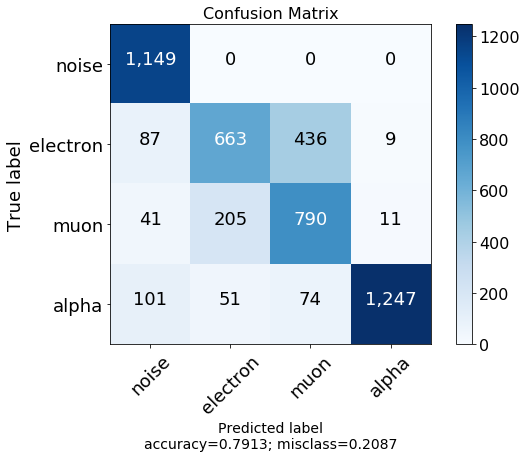

In [30]:
conf1 = confusion_matrix(true_labels, y_predicted1, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

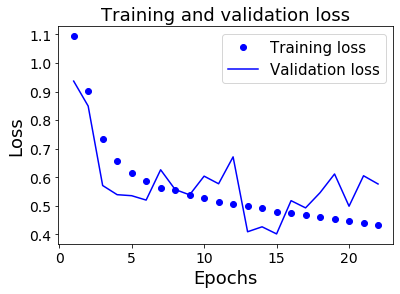

In [31]:
history_n1 = historyv1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [19]:
target_names=['noise','electron', 'muon','alpha']

In [33]:
print(classification_report(true_labels, y_predicted1, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.83      1.00      0.91      1149
    electron       0.72      0.55      0.63      1195
        muon       0.61      0.75      0.67      1047
       alpha       0.98      0.85      0.91      1473

    accuracy                           0.79      4864
   macro avg       0.79      0.79      0.78      4864
weighted avg       0.80      0.79      0.79      4864



### Model 2: 72 neurons, dropouts

In [20]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dropout((0.5)))
model_v2.add(layers.Dense(units= 72, activation='relu'))
model_v2.add(layers.Dropout((0.25)))
model_v2.add(layers.Dense(units= 4, activation='softmax'))
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 128)      

In [21]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [22]:
historyv2 = model_v2.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75, callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 346s 2s/step - loss: 1.1984 - acc: 0.4853 - val_loss: 1.0072 - val_acc: 0.5296
Epoch 2/40
225/225 [==============================] - 337s 1s/step - loss: 1.0147 - acc: 0.5771 - val_loss: 0.8527 - val_acc: 0.6444
Epoch 3/40
225/225 [==============================] - 357s 2s/step - loss: 0.8228 - acc: 0.6468 - val_loss: 0.5865 - val_acc: 0.6727
Epoch 4/40
225/225 [==============================] - 379s 2s/step - loss: 0.7650 - acc: 0.6636 - val_loss: 0.7027 - val_acc: 0.6804
Epoch 5/40
225/225 [==============================] - 385s 2s/step - loss: 0.7209 - acc: 0.6827 - val_loss: 0.7553 - val_acc: 0.6988
Epoch 6/40
225/225 [==============================] - 371s 2s/step - loss: 0.6960 - acc: 0.6891 - val_loss: 0.6757 - val_acc: 0.7073
Epoch 7/40
225/225 [==============================] - 361s 2s/step - loss: 0.6771 - acc: 0.6982 - val_loss: 0.6512 - val_acc: 0.7173
Epoch 8/40
225/225 [==============================] - 358s 2s/step - 

In [23]:
model_v2.save('models/e_mu_a_n_Nv2.h5')

In [24]:
loss, acc = model_v2.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 80.45%


In [25]:
y_predicted2 = model_v2.predict_generator(test_generator(X), steps=76)

y_predicted2 = np.argmax(y_predicted2, axis=1)

true_labels = gen_true_y()

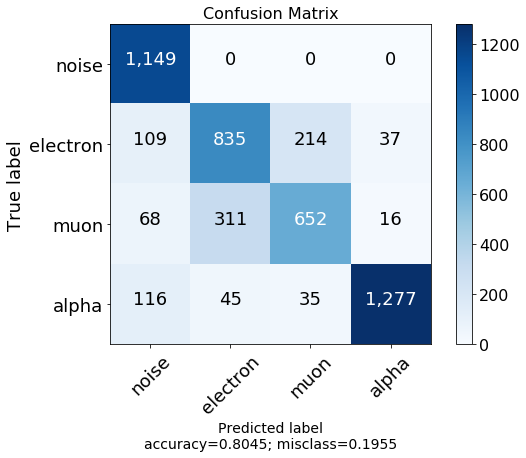

In [26]:
conf2 = confusion_matrix(true_labels, y_predicted2, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

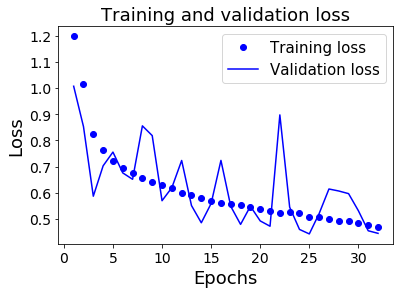

In [27]:
history_n1 = historyv2.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [28]:
print(classification_report(true_labels, y_predicted2, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.80      1.00      0.89      1149
    electron       0.70      0.70      0.70      1195
        muon       0.72      0.62      0.67      1047
       alpha       0.96      0.87      0.91      1473

    accuracy                           0.80      4864
   macro avg       0.80      0.80      0.79      4864
weighted avg       0.81      0.80      0.80      4864



### Model 3: 82 neurons, dropouts (best model)

In [29]:
model_v6 = models.Sequential()
model_v6.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))
model_v6.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v6.add(layers.MaxPooling2D((2,2)))

model_v6.add(layers.Flatten())
model_v6.add(layers.Dropout((0.5)))
model_v6.add(layers.Dense(units= 82, activation='relu'))
model_v6.add(layers.Dropout((0.25)))
model_v6.add(layers.Dense(units= 4, activation='softmax'))
model_v6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 21, 128)      

In [30]:
model_v6.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [31]:
historyv6 = model_v6.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 321s 1s/step - loss: 1.0956 - acc: 0.5323 - val_loss: 0.8321 - val_acc: 0.6077
Epoch 2/40
225/225 [==============================] - 322s 1s/step - loss: 0.8776 - acc: 0.6180 - val_loss: 0.8845 - val_acc: 0.6444
Epoch 3/40
225/225 [==============================] - 322s 1s/step - loss: 0.8066 - acc: 0.6510 - val_loss: 0.8983 - val_acc: 0.6752
Epoch 4/40
225/225 [==============================] - 321s 1s/step - loss: 0.7385 - acc: 0.6831 - val_loss: 0.5836 - val_acc: 0.6998
Epoch 5/40
225/225 [==============================] - 333s 1s/step - loss: 0.6953 - acc: 0.7028 - val_loss: 0.6525 - val_acc: 0.6954
Epoch 6/40
225/225 [==============================] - 339s 2s/step - loss: 0.6592 - acc: 0.7217 - val_loss: 0.5444 - val_acc: 0.7150
Epoch 7/40
225/225 [==============================] - 326s 1s/step - loss: 0.6294 - acc: 0.7364 - val_loss: 0.6479 - val_acc: 0.7221
Epoch 8/40
225/225 [==============================] - 338s 2s/step - 

In [33]:
loss, acc = model_v6.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 81.25%


In [34]:
model_v6.save('models/e_mu_a_n_Nv3.h5')

In [36]:
y_predicted6 = model_v6.predict_generator(test_generator(X), steps=76)

y_predicted6 = np.argmax(y_predicted6, axis=1)

true_labels = gen_true_y()

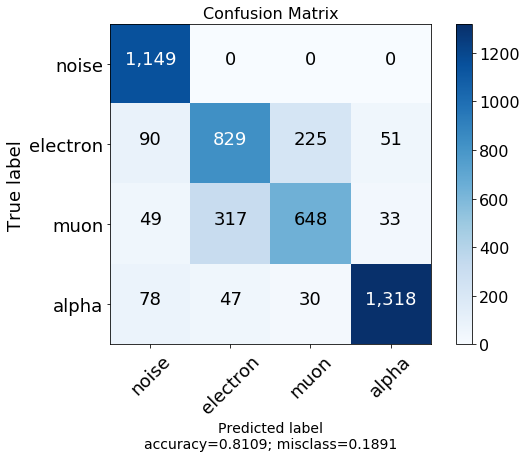

In [37]:
conf6 = confusion_matrix(true_labels, y_predicted6, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf6, 
                      normalize    = False,
                      target_names = ['noise','electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

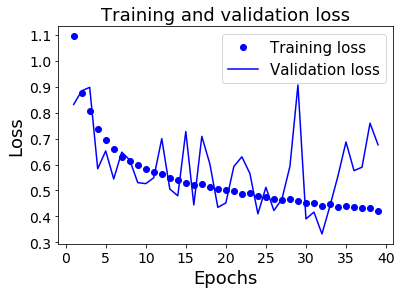

In [38]:
history_n1 = historyv6.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [39]:
print(classification_report(true_labels, y_predicted6, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.84      1.00      0.91      1149
    electron       0.69      0.69      0.69      1195
        muon       0.72      0.62      0.66      1047
       alpha       0.94      0.89      0.92      1473

    accuracy                           0.81      4864
   macro avg       0.80      0.80      0.80      4864
weighted avg       0.81      0.81      0.81      4864



### Model 4: 82 neurons, more filters

In [20]:
model_v7 = models.Sequential()
model_v7.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))
model_v7.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v7.add(layers.MaxPooling2D((2,2)))

model_v7.add(layers.Flatten())
model_v7.add(layers.Dropout((0.5)))
model_v7.add(layers.Dense(units= 82, activation='relu'))
model_v7.add(layers.Dropout((0.25)))
model_v7.add(layers.Dense(units= 4, activation='softmax'))
model_v7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 20, 128)      

In [21]:
model_v7.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [22]:
historyv7 = model_v7.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 313s 1s/step - loss: 1.1511 - acc: 0.5219 - val_loss: 0.9246 - val_acc: 0.5694
Epoch 2/40
225/225 [==============================] - 320s 1s/step - loss: 0.8892 - acc: 0.6081 - val_loss: 0.6450 - val_acc: 0.6592
Epoch 3/40
225/225 [==============================] - 322s 1s/step - loss: 0.7731 - acc: 0.6590 - val_loss: 0.7376 - val_acc: 0.6840
Epoch 4/40
225/225 [==============================] - 324s 1s/step - loss: 0.7269 - acc: 0.6800 - val_loss: 0.5709 - val_acc: 0.6944
Epoch 5/40
225/225 [==============================] - 325s 1s/step - loss: 0.6888 - acc: 0.6924 - val_loss: 0.5986 - val_acc: 0.7146
Epoch 6/40
225/225 [==============================] - 326s 1s/step - loss: 0.6574 - acc: 0.7133 - val_loss: 0.5626 - val_acc: 0.7448
Epoch 7/40
225/225 [==============================] - 327s 1s/step - loss: 0.6401 - acc: 0.7259 - val_loss: 0.5042 - val_acc: 0.7369
Epoch 8/40
225/225 [==============================] - 362s 2s/step - 

In [23]:
model_v7.save('models/e_mu_a_n_Nv4.h5')

In [24]:
loss, acc = model_v7.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 79.87%


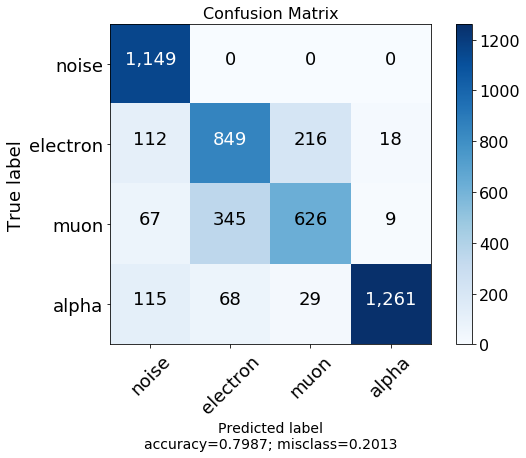

In [25]:
y_predicted7 = model_v7.predict_generator(test_generator(X), steps=76)

y_predicted7 = np.argmax(y_predicted7, axis=1)

true_labels = gen_true_y()

conf7 = confusion_matrix(true_labels, y_predicted7, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf7, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

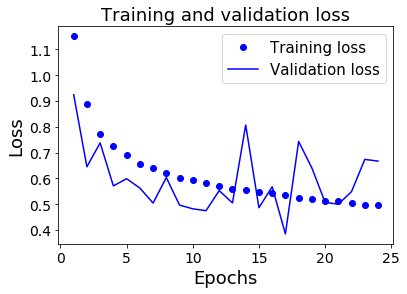

In [26]:
history_n1 = historyv7.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [27]:
print(classification_report(true_labels, y_predicted7, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.80      1.00      0.89      1149
    electron       0.67      0.71      0.69      1195
        muon       0.72      0.60      0.65      1047
       alpha       0.98      0.86      0.91      1473

    accuracy                           0.80      4864
   macro avg       0.79      0.79      0.79      4864
weighted avg       0.80      0.80      0.80      4864



### Model 5: 92 neurons, dropouts

In [28]:
model_v9 = models.Sequential()
model_v9.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(32,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))
model_v9.add(layers.Conv2D(128,(2,2), activation='relu'))
model_v9.add(layers.MaxPooling2D((2,2)))

model_v9.add(layers.Flatten())
model_v9.add(layers.Dropout((0.5)))
model_v9.add(layers.Dense(units= 92, activation='relu'))
model_v9.add(layers.Dropout((0.25)))
model_v9.add(layers.Dense(units= 4, activation='softmax'))
model_v9.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 190, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 95, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 118, 93, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 20, 64)       

In [29]:
model_v9.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='categorical_crossentropy', metrics=['acc'])

In [30]:
historyv9 = model_v9.fit_generator(train_gen, epochs=40, validation_data=val_gen, 
                                   steps_per_epoch= 225, validation_steps= 75,callbacks=my_callbacks)

Epoch 1/40
225/225 [==============================] - 348s 2s/step - loss: 1.1769 - acc: 0.4908 - val_loss: 1.0575 - val_acc: 0.5633
Epoch 2/40
225/225 [==============================] - 335s 1s/step - loss: 0.9598 - acc: 0.6015 - val_loss: 0.9354 - val_acc: 0.6463
Epoch 3/40
225/225 [==============================] - 333s 1s/step - loss: 0.8249 - acc: 0.6451 - val_loss: 0.7133 - val_acc: 0.6740
Epoch 4/40
225/225 [==============================] - 347s 2s/step - loss: 0.7617 - acc: 0.6774 - val_loss: 0.6928 - val_acc: 0.6996
Epoch 5/40
225/225 [==============================] - 339s 2s/step - loss: 0.7266 - acc: 0.6851 - val_loss: 0.6520 - val_acc: 0.7165
Epoch 6/40
225/225 [==============================] - 334s 1s/step - loss: 0.7023 - acc: 0.7017 - val_loss: 0.6565 - val_acc: 0.7277
Epoch 7/40
225/225 [==============================] - 336s 1s/step - loss: 0.6753 - acc: 0.7092 - val_loss: 0.7047 - val_acc: 0.7287
Epoch 8/40
225/225 [==============================] - 332s 1s/step - 

In [31]:
model_v9.save('models/e_mu_a_n_Nv5.h5')

In [32]:
loss, acc = model_v9.evaluate_generator(test_gen, steps=76)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

Accuracy with the model: 77.86%


In [33]:
y_predicted9 = model_v9.predict_generator(test_generator(X), steps=76)

y_predicted9 = np.argmax(y_predicted9, axis=1)

true_labels = gen_true_y()

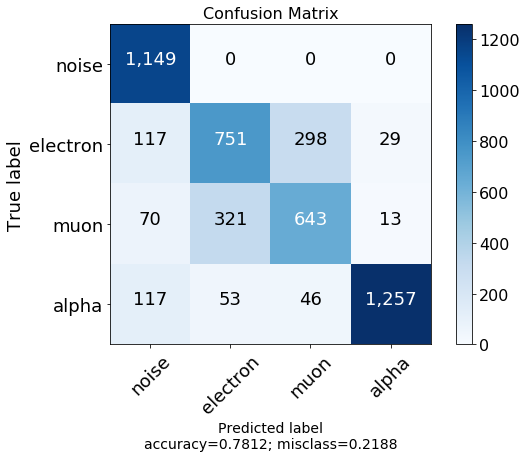

In [34]:
conf9 = confusion_matrix(true_labels, y_predicted9, labels = list([0,1,2,3]))
plot_confusion_matrix(cm           = conf9, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

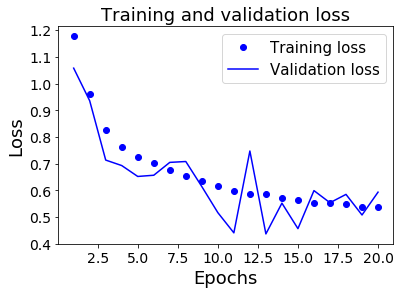

In [35]:
history_n1 = historyv9.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [36]:
print(classification_report(true_labels, y_predicted9, target_names=target_names))

              precision    recall  f1-score   support

       noise       0.79      1.00      0.88      1149
    electron       0.67      0.63      0.65      1195
        muon       0.65      0.61      0.63      1047
       alpha       0.97      0.85      0.91      1473

    accuracy                           0.78      4864
   macro avg       0.77      0.77      0.77      4864
weighted avg       0.78      0.78      0.78      4864

